# Introduction
---
This is our attempt at the [US Patent Phrase-to-phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching) Kaggle competition. From a large, text-based dataset derived from inventions, we are tasked to train models on a novel semantic similarity dataset to extract relevant information by matching key phrases in patent documents.

# Imports and Data
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import spacy
import torch
from tqdm import tqdm
tqdm.pandas(bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
train = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/train.csv')
test = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/test.csv')
sub = pd.read_csv('../input/us-patent-phrase-to-phrase-matching/sample_submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


In [4]:
train.head(10)

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
5,067203128142739c,abatement,greenhouse gases,A47,0.25
6,061d17f04be2d1cf,abatement,increased rate,A47,0.25
7,e1f44e48399a2027,abatement,measurement level,A47,0.25
8,0a425937a3e86d10,abatement,minimising sounds,A47,0.50
9,ef2d4c2e6bbb208d,abatement,mixing core materials,A47,0.25


In [5]:
print(test.info())
print('~.'*40)
print(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       36 non-null     object
 1   anchor   36 non-null     object
 2   target   36 non-null     object
 3   context  36 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB
None
~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
                 id              anchor                         target context
0  4112d61851461f60            opc drum  inorganic photoconductor drum     G02
1  09e418c93a776564     adjust gas flow              altering gas flow     F23
2  36baf228038e314b      lower trunnion                 lower locating     B60
3  1f37ead645e7f0c8       cap component                  upper portion     D06
4  71a5b6ad068d531f  neural stimulation      artificial neural network     H04


In [6]:
sub.head()

,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


# Data Processing
---

check for duplicated and nulls

In [7]:
train.isnull().sum(axis=0)

id         0
anchor     0
target     0
context    0
score      0
dtype: int64

In [8]:
train.duplicated().sum()

0

In [9]:
train.head(10)

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
5,067203128142739c,abatement,greenhouse gases,A47,0.25
6,061d17f04be2d1cf,abatement,increased rate,A47,0.25
7,e1f44e48399a2027,abatement,measurement level,A47,0.25
8,0a425937a3e86d10,abatement,minimising sounds,A47,0.50
9,ef2d4c2e6bbb208d,abatement,mixing core materials,A47,0.25


no null or duplicated values, not much cleaning to do.

# EDA
---
column by column approach

## anchor column

`anchor` column provides the topics which need to be matched with the `target` column. we can first examine the frequency of the number of targets per anchor.

In [10]:
train.anchor.nunique()

733

In [11]:
train[train['anchor'] == 'el display'].head(20)

,id,anchor,target,context,score
10542,78a51b0cc51c9519,el display,display,C23,0.50
10543,913df62644b7e479,el display,el device,C23,0.50
10544,9a76261779bbcbe2,el display,el display device,C23,0.50
10545,8a824c91563ad370,el display,el emitting,C23,0.50
10546,d1ffa91cd7716f73,el display,el emitting device,C23,0.50
10547,80a487787ecc5958,el display,el panel,C23,0.50
10548,909a7684ef8d3749,el display,electro display,C23,0.50
10549,241b91b6e43be647,el display,electro emitting,C23,0.25
10550,4bfff4e53efdad10,el display,electro emitting display,C23,0.50
10551,47021526c301b08d,el display,electroluminescence,C23,0.50


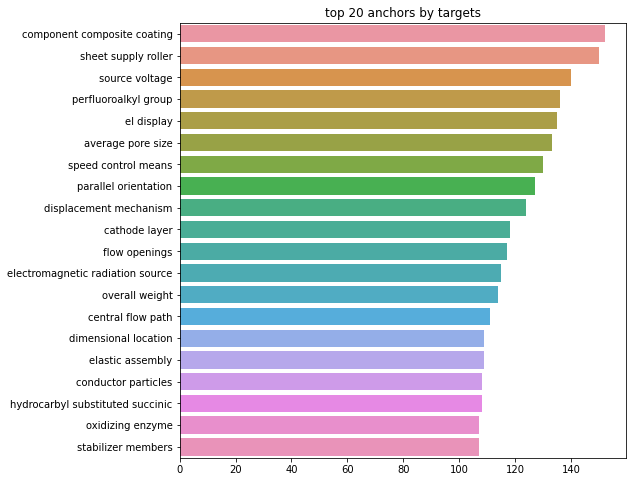

In [12]:
plt.figure(figsize=(8,8))
plt.title('top 20 anchors by targets')
count = Counter(train['anchor'])
x,y=map(list,zip(*count.most_common(20)))
sns.barplot(x=y,y=x);

In [13]:
print('Top 10 most frequent anchors:')
print('*'*40)
train.anchor.value_counts().head(10)

Top 10 most frequent anchors:
****************************************


component composite coating    152
sheet supply roller            150
source voltage                 140
perfluoroalkyl group           136
el display                     135
average pore size              133
speed control means            130
parallel orientation           127
displacement mechanism         124
cathode layer                  118
Name: anchor, dtype: int64

In [14]:
print('Bottom 10 most frequent anchors:')
print('*'*40)
train.anchor.value_counts(ascending=True).head(10)

Bottom 10 most frequent anchors:
****************************************


conduct conducting material               1
peripheral nervous system stimulation     1
dry coating composition1                  2
plug nozzle                               2
shannon                                   2
external boundary                         4
sulfide sulfur                            6
heighth                                   7
index with location                       8
corresponding toothed                    12
Name: anchor, dtype: int64

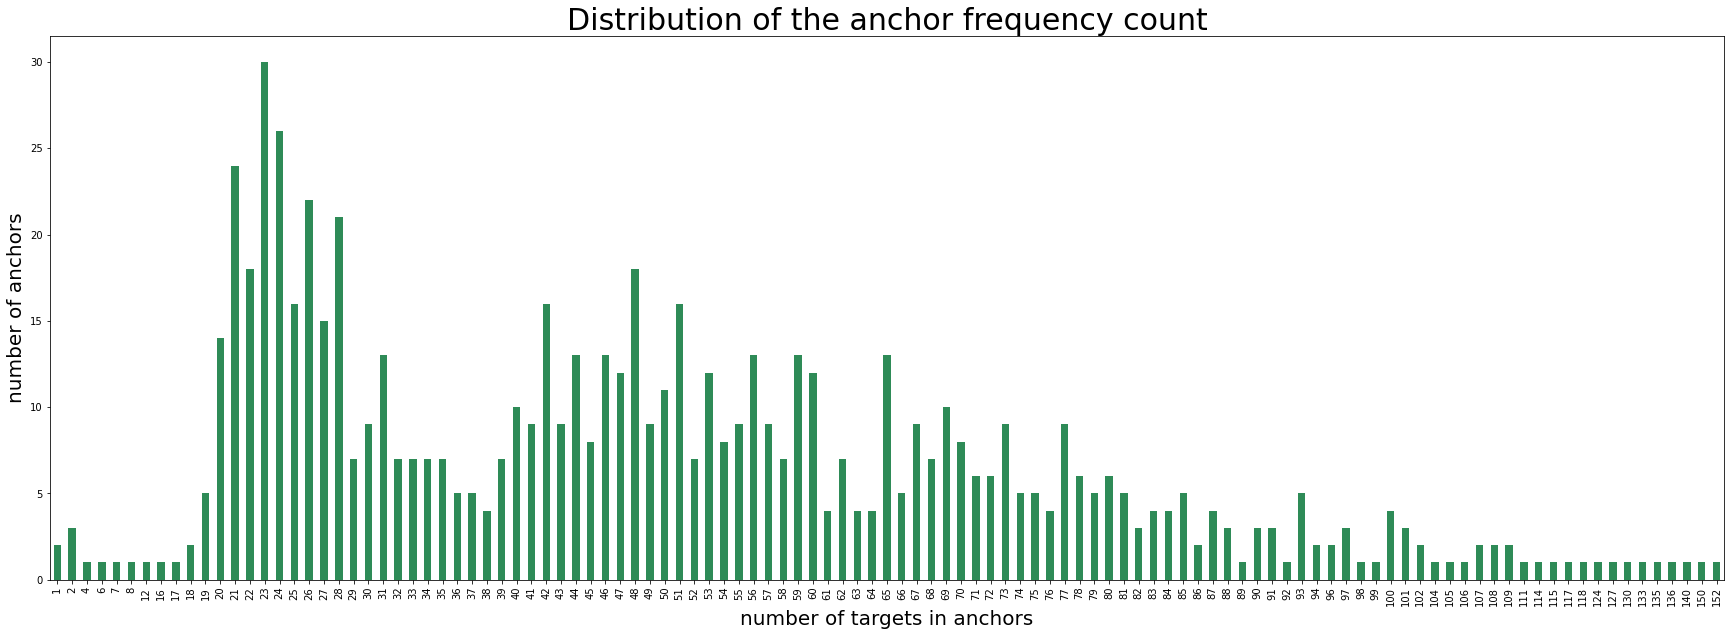

In [15]:
val = train.anchor.value_counts()
plt.figure(figsize=(30,10))
plt.title('Distribution of the anchor frequency count', fontsize=30) # basically how many anchors (y) occur x times
val.groupby(val).count().plot(kind='bar', color='seagreen')
plt.xlabel('number of targets in anchors', fontsize=20)
plt.ylabel('number of anchors', fontsize=20);

In [16]:
train['anchor'].str.split().map(lambda x: len(x)).value_counts()

2    24485
3     7556
1     3377
4      856
5      199
Name: anchor, dtype: int64

the number of words range from 1 to 5, and we can see the distribution more clearly in a histogram.

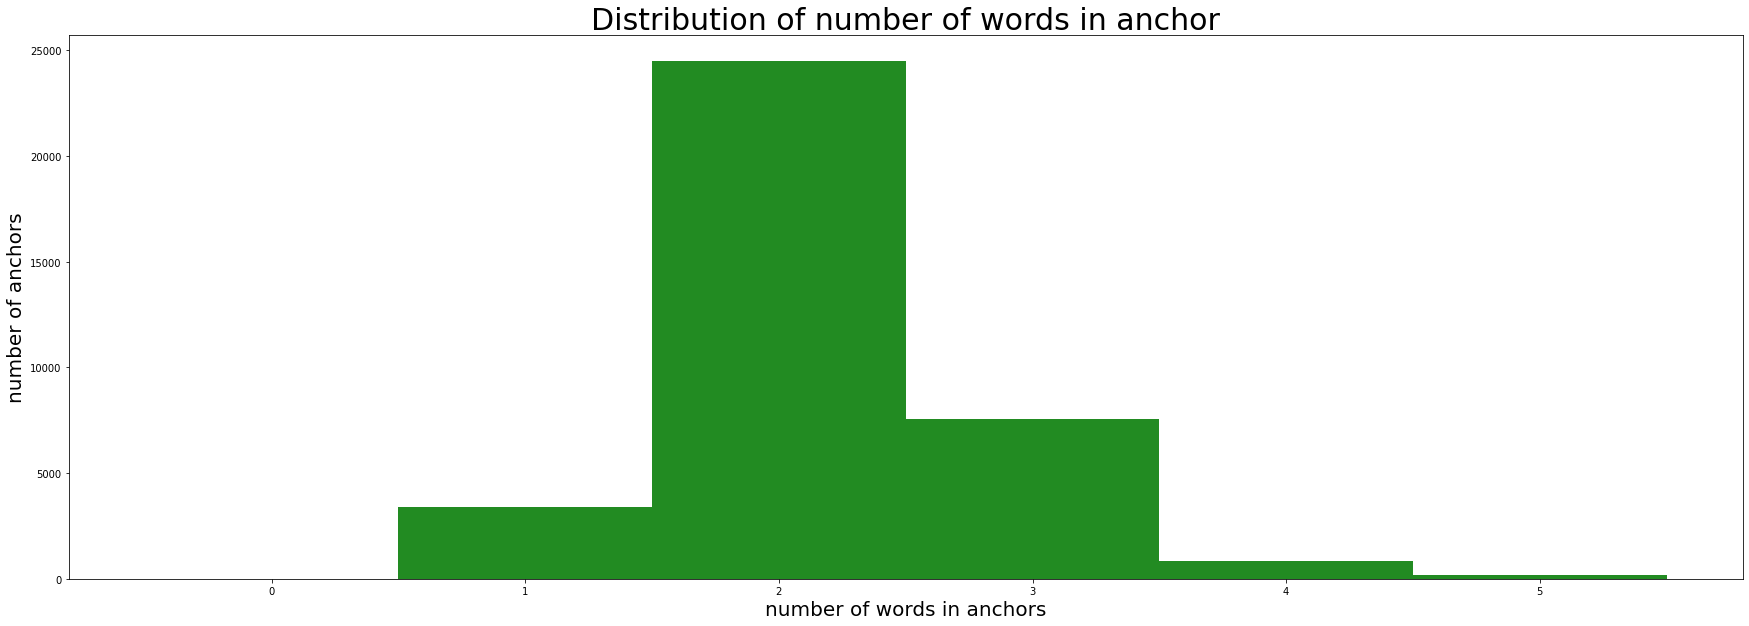

In [17]:
plt.figure(figsize=(30,10))
plt.title('Distribution of number of words in anchor', fontsize=30) # basically how many anchors (y) occur x times
plt.hist(train['anchor'].str.split().map(lambda x: len(x)), color='forestgreen', bins=np.arange(7)-0.5)
plt.xlabel('number of words in anchors', fontsize=20)
plt.ylabel('number of anchors', fontsize=20);

## target column

we can perform similar EDA with this column, because it serves a similar purpose to the `anchor` column

In [18]:
train.target.nunique()

29340

In [19]:
train.target.value_counts().head(10)

composition     24
data            22
metal           22
motor           22
assembly        21
substrate       20
component       19
transmission    19
output          19
pressure        19
Name: target, dtype: int64

In [20]:
train[train['target'] == 'data']

,id,anchor,target,context,score
54,856cef1a4eefc3aa,abnormal position,data,B23,0.25
359,23090ec49265de76,ack,data,G04,0.50
382,35ad64716a1f895e,ack,data,G06,0.25
3572,d71ee59bfb53690b,board id,data,G01,0.50
4110,af03db7407451a05,cache segments,data,G06,0.50
5502,8a5cd26a3fdb6175,clear buffer,data,G02,0.25
5538,30b6dc115260849c,clock input,data,G04,0.50
6019,18317f6f93d28cdc,color difference signal,data,H04,0.25
6779,fc2ec983500fb690,conductive position,data,B23,0.00
18461,168fea406eecd47f,linear systems,data,G06,0.50


it seems like this is not a bijective relationship. the targets are many-to-one, e.g. 'data' in the target column is matched to 'multiplexed data' 3 times with varying similarity scores. therefore the columns are [non-injective](https://en.wikipedia.org/wiki/Injective_function), in that there are multiple anchors that match to one target and multiple targets that are matched to one anchor. this seems like it will be a problem

In [21]:
print('Top 10 most frequent targets:')
print('*'*40)
train.target.value_counts().head(10)

Top 10 most frequent targets:
****************************************


composition     24
data            22
metal           22
motor           22
assembly        21
substrate       20
component       19
transmission    19
output          19
pressure        19
Name: target, dtype: int64

In [22]:
print('Bottom 10 most frequent targets:')
print('*'*40)
train.target.value_counts(ascending=True).head(10)

Bottom 10 most frequent targets:
****************************************


abatement of pollution     1
weight total wt            1
weight machine             1
weight loss                1
weight in percentage       1
total oxide weight         1
total oxide composition    1
total composition          1
substituted amount         1
parts by weight            1
Name: target, dtype: int64

In [23]:
# not sure this is useful, or how to interpret this

# tval = train.target.value_counts()
# plt.figure(figsize=(30,10))
# plt.title('Distribution of the anchor frequency count', fontsize=30) # basically how many anchors (y) occur x times
# tval.groupby(tval).count().plot(kind='bar', color='seagreen')
# plt.xlabel('number of targets in anchors', fontsize=20)
# plt.ylabel('number of anchors', fontsize=20);

In [24]:
train['target'].str.split().map(lambda x: len(x)).value_counts()

2     19099
3      8503
1      6872
4      1606
5       272
6        76
7        26
8         7
10        3
9         3
13        2
12        2
15        1
11        1
Name: target, dtype: int64

the number of words range from 1 to 5, and we can see the distribution more clearly in a histogram.

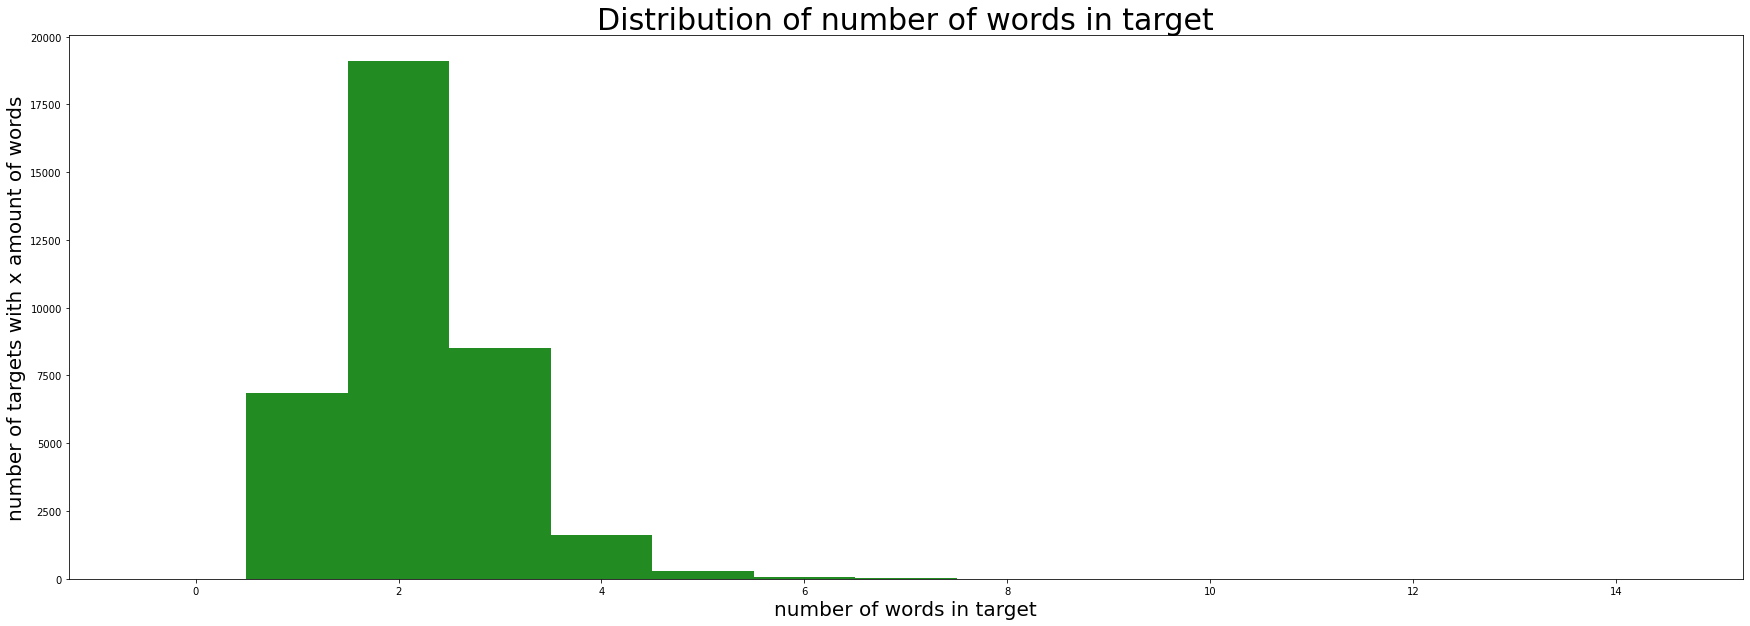

In [25]:
plt.figure(figsize=(30,10))
plt.title('Distribution of number of words in target', fontsize=30) # basically how many anchors (y) occur x times
plt.hist(train['target'].str.split().map(lambda x: len(x)), bins=np.arange(16)-0.5, color='forestgreen')
plt.xlabel('number of words in target', fontsize=20)
plt.ylabel('number of targets with x amount of words', fontsize=20);

the distribution clearly has a very long tail.

## context column

based on the [Cooperative Patent Classification](https://en.wikipedia.org/wiki/Cooperative_Patent_Classification) system, the first letter represents the section (category) of the patent:
- A: Human Necessities
- B: Operations and Transport
- C: Chemistry and Metallurgy
- D: Textiles
- E: Fixed Constructions
- F: Mechanical Engineering
- G: Physics
- H: Electricity
- Y: Emerging Cross-Sectional Technologies

while the next 2 numerical digits represent the class. The full catalog can be found on the [CPC website](https://www.cooperativepatentclassification.org/cpcSchemeAndDefinitions/table)

In [26]:
train.context.nunique()

106

In [27]:
train.context.value_counts().head(20)

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
C07    1069
G06    1063
B60     916
B01     891
G02     877
H03     798
B65     764
B41     650
C08     649
B23     648
A01     637
C12     633
C10     601
B29     593
F02     566
Name: context, dtype: int64

## score column

this is our dependent variable. this column gives the closeness of the target to the anchor on a scale of 0 (irrelevant) to 1 (very close match). we can take a look at the distribution of scores.

In [28]:
train.score.value_counts()

0.50    12300
0.25    11519
0.00     7471
0.75     4029
1.00     1154
Name: score, dtype: int64

<AxesSubplot:title={'center':'Distribution of scores'}, xlabel='scores', ylabel='count'>

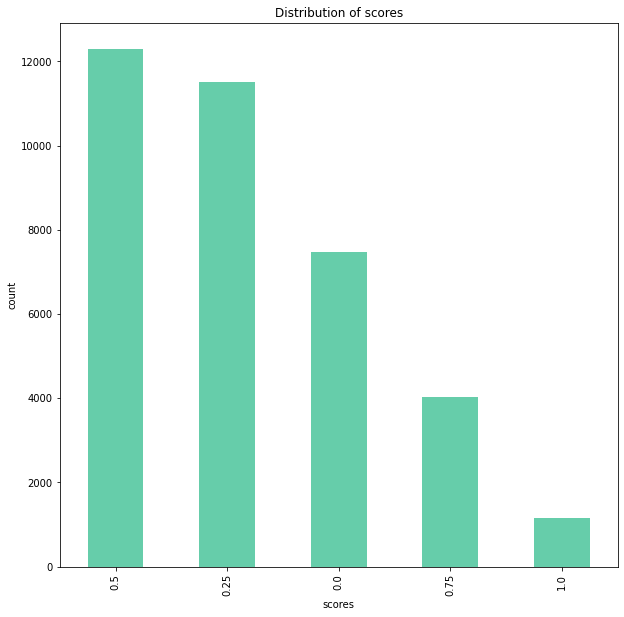

In [29]:
plt.figure(figsize=(10,10))
plt.xlabel('scores')
plt.ylabel('count')
plt.title('Distribution of scores')
train.score.value_counts().plot(kind='bar', color='mediumaquamarine')

it seems that most of the word pairs are synonyms and somewhat related rather than closely related. this also seems like a multi-class problem with imbalanced classes.  

# feature engineering

- possibly combine CPC labels so we have more words to train the model
- ner/pos tagging

## CPC labels
obtained from [CPC meaning dataset](https://www.kaggle.com/datasets/xhlulu/cpc-codes), more details on how to incorporate it can be gained from [Remek Kinas' Notebook](https://www.kaggle.com/code/remekkinas/eda-and-feature-engineering)

In [30]:
cpc_codes = pd.read_csv("../input/cpc-codes/titles.csv", dtype=str)
cpc_codes.head(10)

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,01,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,01,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,01,B,1,00
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,01,B,1,02
5,A01B1/022,{Collapsible; extensible; combinations with ot...,A,01,B,1,022
6,A01B1/024,{Foot protectors attached to the blade},A,01,B,1,024
7,A01B1/026,{with auxiliary handles for facilitating lifting},A,01,B,1,026
8,A01B1/028,{with ground abutment shoes or earth anchors f...,A,01,B,1,028
9,A01B1/04,with teeth,A,01,B,1,04


In [31]:
train['context_text'] = train['context'].map(cpc_codes.set_index('code')['title']).str.lower()
train.head()

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,furniture; domestic articles or appliances; co...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,furniture; domestic articles or appliances; co...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,furniture; domestic articles or appliances; co...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,furniture; domestic articles or appliances; co...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,furniture; domestic articles or appliances; co...


In [32]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
train.head()

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,furniture; domestic articles or appliances; co...,abatement[SEP]abatement of pollution[SEP]furni...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,furniture; domestic articles or appliances; co...,abatement[SEP]act of abating[SEP]furniture; do...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,furniture; domestic articles or appliances; co...,abatement[SEP]active catalyst[SEP]furniture; d...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,furniture; domestic articles or appliances; co...,abatement[SEP]eliminating process[SEP]furnitur...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,furniture; domestic articles or appliances; co...,abatement[SEP]forest region[SEP]furniture; dom...


In [33]:
test['context_text'] = test['context'].map(cpc_codes.set_index('code')['title']).str.lower()
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
test.head()

,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,optics,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,combustion apparatus; combustion processes,adjust gas flow[SEP]altering gas flow[SEP]comb...
2,36baf228038e314b,lower trunnion,lower locating,B60,vehicles in general,lower trunnion[SEP]lower locating[SEP]vehicles...
3,1f37ead645e7f0c8,cap component,upper portion,D06,treatment of textiles or the like; laundering;...,cap component[SEP]upper portion[SEP]treatment ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,electric communication technique,neural stimulation[SEP]artificial neural netwo...


## stratified k fold (undone)

[reference](https://www.kaggle.com/code/backup1123/pytorch-k-fold-cross-validation-dataloader/notebook)

In [34]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [35]:
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
train.head()

,id,anchor,target,context,score,context_text,text,score_map
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,furniture; domestic articles or appliances; co...,abatement[SEP]abatement of pollution[SEP]furni...,2
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,furniture; domestic articles or appliances; co...,abatement[SEP]act of abating[SEP]furniture; do...,3
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,furniture; domestic articles or appliances; co...,abatement[SEP]active catalyst[SEP]furniture; d...,1
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,furniture; domestic articles or appliances; co...,abatement[SEP]eliminating process[SEP]furnitur...,2
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,furniture; domestic articles or appliances; co...,abatement[SEP]forest region[SEP]furniture; dom...,0


In [36]:
X_train, X_val = train_test_split(
    train, test_size=0.3, random_state=42
)

In [37]:
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

# pickling dataset

In [38]:
X_train.to_pickle('train.pkl')
X_val.to_pickle('val.pkl')
test.to_pickle('test.pkl')

# modelling
---
probably use 2 models:
1. [t5 for multi-label classification](https://www.kaggle.com/code/prithvijaunjale/t5-multi-label-classification/notebook) (they used BCS and AdamW which are wrong)
2. [deberta](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train/notebook) (more optimized BERT, upgraded from roberta)

explore:
1. [raytune](https://www.ray.io/ray-tune)
2. wandb
3. oof (out-of-fold) validation